In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from scipy import stats
import statsmodels.api as sm
import csv
import glob

In [2]:
df = pd.read_csv('CSVFiles/all_data_with_identities_50000.csv')

df = df.loc[:, ["comment_text", "split", "toxicity", "male", "female", "LGBTQ", "christian", "muslim", "other_religions", "black", "white"]]
df = df[df['split'] == 'test']

df['male'] = df['male'].apply(lambda x: np.round(x>=0.5))
df['female'] = df['female'].apply(lambda x: np.round(x>=0.5))
df['LGBTQ'] = df['LGBTQ'].apply(lambda x: np.round(x>=0.5))
df['christian'] = df['christian'].apply(lambda x: np.round(x>=0.5))
df['muslim'] = df['muslim'].apply(lambda x: np.round(x>=0.5))
df['other_religions'] = df['other_religions'].apply(lambda x: np.round(x>=0.5))
df['black'] = df['black'].apply(lambda x: np.round(x>=0.5))
df['white'] = df['white'].apply(lambda x: np.round(x>=0.5))

In [4]:
def CheckAccuracy(predictions, labels):
        acc = 0.0
        for i in range(len(predictions)):
            if (predictions[i] == labels[i]):
                acc += 1
        return acc/len(predictions)

def F1AndAcc(df):
    f1_scores = []
    accuracies = []
    demographics = []
    
    for col in df.columns[4:]:
        tempdf = df[(df[col] == 1)]        
        
        labels = np.array(tempdf['toxicity'].values.tolist())
        predictions = np.array(tempdf['test predictions'].values.tolist())
        
        f1_scores.append(f1_score(labels, predictions, zero_division=1))
        accuracies.append(CheckAccuracy(labels, predictions))   
    return np.array(f1_scores), np.array(accuracies)


def pRule(df):
    pRules = []
    
    for col in df.columns[4:]:
        
        tempdfz1 = df[(df[col] == 1)]      
        tempdfz0 = df[(df[col] == 0)]
        
        labelsz1 = np.array(tempdfz1['toxicity'].values.tolist())
        predictionsz1 = np.array(tempdfz1['test predictions'].values.tolist())
        
        labelsz0 = np.array(tempdfz0['toxicity'].values.tolist())
        predictionsz0 = np.array(tempdfz0['test predictions'].values.tolist())
        
        with np.errstate(divide='ignore'):
            
            z1Ut1 = np.sum(predictionsz1)/len(df)
            pz1 = len(predictionsz1)/len(df)
            
            z0Ut1 = np.sum(predictionsz0)/len(df)
            pz0 = len(predictionsz0)/len(df)
            
            pscore0 = (z1Ut1/pz1) / (z0Ut1/pz0)
            pscore1 = (z0Ut1/pz0) / (z1Ut1/pz1)
        
        if np.isnan(pscore0) or np.isnan(pscore1):
            finalpscore = 0
        else:
            finalpscore = min(pscore0, pscore1)
        
        pRules.append(finalpscore)
    return pRules


def pRuleOwn(df):
    pRules = []
    
    for col in df.columns[4:]:
        tempdfz1 = df[(df[col] == 1)]      
        tempdfz0 = df[(df[col] == 0)]
        
        labelsz1 = np.array(tempdfz1['toxicity'].values.tolist())
        predictionsz1 = np.array(tempdfz1['test predictions'].values.tolist())
        
        labelsz0 = np.array(tempdfz0['toxicity'].values.tolist())
        predictionsz0 = np.array(tempdfz0['test predictions'].values.tolist())
        
        with np.errstate(divide='ignore'):
            pscore0 = (np.sum(predictionsz1)/np.sum(labelsz1))/(np.sum(predictionsz0)/np.sum(labelsz0))
            pscore1 = (np.sum(predictionsz0)/np.sum(labelsz0))/(np.sum(predictionsz1)/np.sum(labelsz1))
        
        if np.isnan(pscore0) or np.isnan(pscore1):
            finalpscore = 0
        else:
            finalpscore = min(pscore0, pscore1)
        
        pRules.append(finalpscore)
    return pRules

def MinMaxFairness(scores):
    return np.max(scores)-np.min(scores)

def VarianceFairness(scores):
    return np.var(scores)


In [5]:
# Checking all privacy models
epsilons = np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5,
                     12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19.5, 20, 20.5, 21, 21.5, 
                     22, 22.5, 23, 23.5, 24, 24.5, 25, 25.5, 26, 26.5, 27, 27.5, 28, 28.5, 29, 29.5, 30])

orderCSV = []
paths1 = []
for csv in glob.glob('finalOwnWilds/logs/50000Every05Run1/Test/*'):
    orderCSV.append(csv[71:75])
    paths1.append(csv)
paths1 = np.array(paths1)[np.argsort(np.array(orderCSV).astype(int))]

orderCSV = []
paths2 = []
for csv in glob.glob('finalOwnWilds/logs/50000Every05Run2/Test/*'):
    orderCSV.append(csv[71:75])
    paths2.append(csv)
paths2 = np.array(paths2)[np.argsort(np.array(orderCSV).astype(int))]

orderCSV = []
paths3 = []
for csv in glob.glob('finalOwnWilds/logs/50000Every05Run3/Test/*'):
    orderCSV.append(csv[70:73])
    paths3.append(csv)
paths3 = np.array(paths3)[np.argsort(np.array(orderCSV).astype(int))]

orderCSV = []
paths4 = []
for csv in glob.glob('finalOwnWilds/logs/50000Every05Run4/Test/*'):
    orderCSV.append(csv[71:75])
    paths4.append(csv)
paths4 = np.array(paths4)[np.argsort(np.array(orderCSV).astype(int))]


orderCSV = []
paths5 = []
for csv in glob.glob('finalOwnWilds/logs/50000Every05Run5/Test/*'):
    orderCSV.append(csv[70:73])
    paths5.append(csv)
paths5 = np.array(paths5)[np.argsort(np.array(orderCSV).astype(int))]

AllPaths = [paths1, paths2, paths3, paths4, paths5]

allvarF1 = []
allminMaxF1 = []
allpRuleOwnMeanArr = []
allpRuleOwnMinArr = []
allpRuleMeanArr = []
allpRuleMinArr = []
allaccuracy = []


for i, run in enumerate(AllPaths):
    
    varF1 = []
    minMaxF1 = []
    pRuleOwnMeanArr = []
    pRuleOwnMinArr = []
    pRuleMeanArr = []
    pRuleMinArr = []
    accuracy = []
    
    for csvFile in run:
        test_preds = pd.read_csv(csvFile, header=None) 
        test_preds = pd.DataFrame({'test predictions': np.array(test_preds.values.tolist()).flatten()}, index = df.index)
        temp_df = pd.concat([test_preds, df], axis=1)
        
        
        f1_scores, accuracies = F1AndAcc(temp_df)
        
        own = pRuleOwn(temp_df)       
        
        pRuleOwnMinArr.append(np.min(own))
        pRuleOwnMeanArr.append(np.mean(own))
        
        official = pRule(temp_df)
        pRuleMinArr.append(np.min(official))
        pRuleMeanArr.append(np.mean(official))

        #F1 Variance
        varF1.append(VarianceFairness(f1_scores))

        #F1 Min Max
        minMaxF1.append(MinMaxFairness(f1_scores))
        
        labels = np.array(temp_df['toxicity'].values.tolist())
        preds = np.array(temp_df['test predictions'].values.tolist())
        accuracy.append(CheckAccuracy(preds,labels))
        
    allvarF1.append(np.array(varF1))
    allminMaxF1.append(np.array(minMaxF1))
    allpRuleOwnMeanArr.append(np.array(pRuleOwnMeanArr))
    allpRuleOwnMinArr.append(np.array(pRuleOwnMinArr))
    allpRuleMeanArr.append(np.array(pRuleMeanArr))
    allpRuleMinArr.append(np.array(pRuleMinArr))
    allaccuracy.append(np.array(accuracy))
    
allvarF1 = np.array(allvarF1).mean(axis=0)
allminMaxF1 = np.array(allminMaxF1).mean(axis=0)
allpRuleOwnMeanArr = np.array(allpRuleOwnMeanArr).mean(axis=0)
allpRuleOwnMinArr = np.array(allpRuleOwnMinArr).mean(axis=0)
allpRuleMeanArr = np.array(allpRuleMeanArr).mean(axis=0)
allpRuleMinArr = np.array(allpRuleMinArr).mean(axis=0)
allaccuracy = np.array(allaccuracy).mean(axis=0)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.376
Date:                Sun, 13 Jun 2021   Prob (F-statistic):              0.129
Time:                        13:45:27   Log-Likelihood:                 113.75
No. Observations:                  60   AIC:                            -223.5
Df Residuals:                      58   BIC:                            -219.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7352      0.010     76.083      0.0

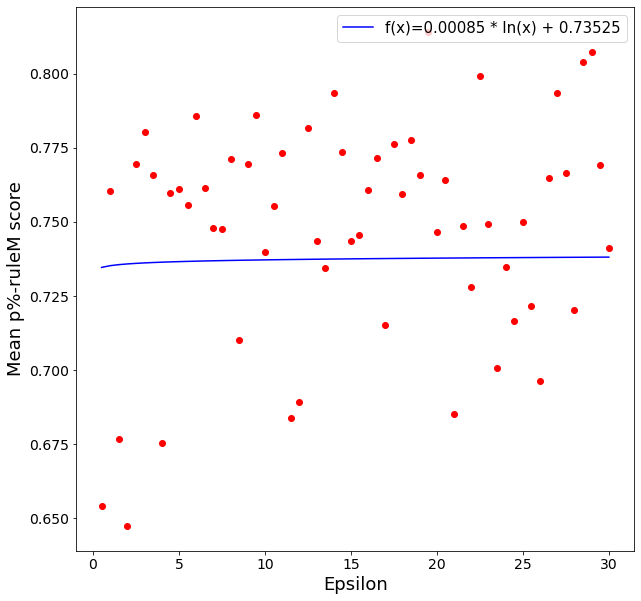

In [6]:
# PLOT OWN P-RULE MEAN

m, b = np.polyfit(epsilons, allpRuleOwnMeanArr, 1)

X2 = sm.add_constant(epsilons)
est = sm.OLS(allpRuleOwnMeanArr, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allpRuleOwnMeanArr, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Mean p%-ruleM score", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper right", fontsize=15)
plt.savefig('5OwnMeanWilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     12.31
Date:                Sun, 13 Jun 2021   Prob (F-statistic):           0.000877
Time:                        13:45:42   Log-Likelihood:                 111.79
No. Observations:                  60   AIC:                            -219.6
Df Residuals:                      58   BIC:                            -215.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5565      0.014     38.653      0.0

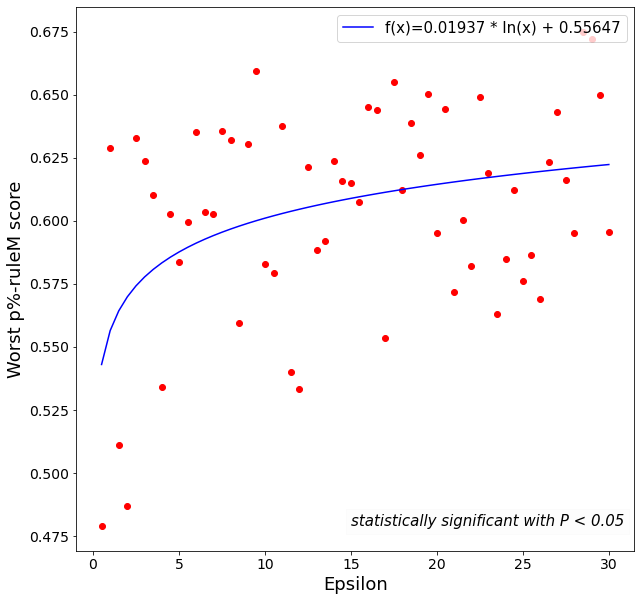

In [7]:
# PLOT OWN P-RULE MIN
m, b = np.polyfit(np.log(epsilons), allpRuleOwnMinArr, 1)

X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allpRuleOwnMinArr, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allpRuleOwnMinArr, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Worst p%-ruleM score", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(15, min(allpRuleOwnMinArr),'statistically significant with P < 0.05', fontsize=15,  color='black',style='italic', bbox={'facecolor': 'grey', 'alpha': 0.01, 'pad': 5})
plt.legend(loc="upper right", fontsize=15)
plt.savefig('5OwnMinWilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.241
Date:                Sun, 13 Jun 2021   Prob (F-statistic):              0.140
Time:                        13:45:50   Log-Likelihood:                 110.91
No. Observations:                  60   AIC:                            -217.8
Df Residuals:                      58   BIC:                            -213.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6815      0.015     46.644      0.0

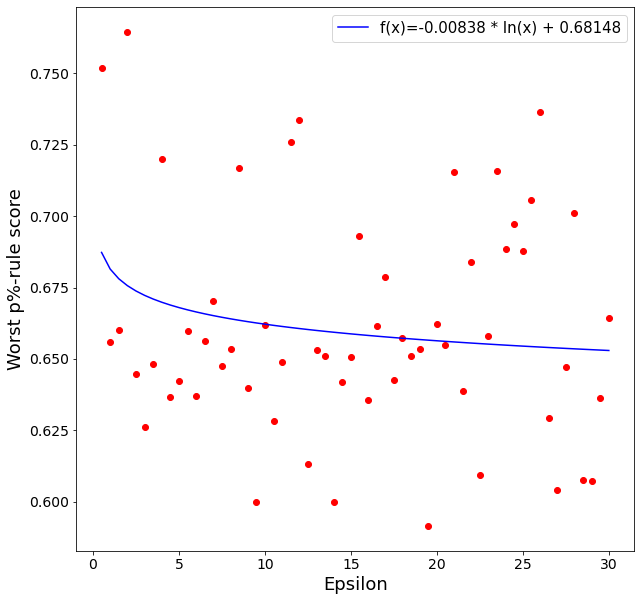

In [8]:
# PLOT OFFICIAL P-RULE MIN

m, b = np.polyfit(np.log(epsilons), allpRuleMinArr, 1)

X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allpRuleMinArr, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allpRuleMinArr, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Worst p%-rule score", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper right", fontsize=15)
plt.savefig('5OfficialMinWilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     5.584
Date:                Sun, 13 Jun 2021   Prob (F-statistic):             0.0215
Time:                        13:46:00   Log-Likelihood:                 119.07
No. Observations:                  60   AIC:                            -234.1
Df Residuals:                      58   BIC:                            -230.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8184      0.013     64.181      0.0

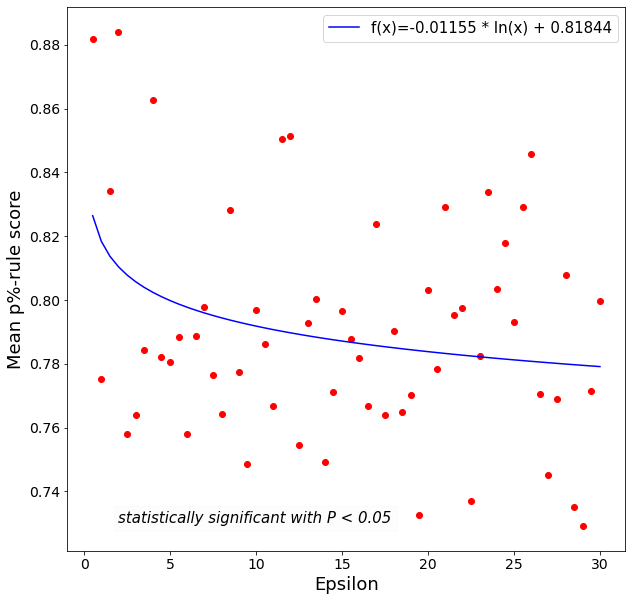

In [9]:
# PLOT OFFICIAL P-RULE Mean

m, b = np.polyfit(np.log(epsilons), allpRuleMeanArr, 1)

X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allpRuleMeanArr, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allpRuleMeanArr, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Mean p%-rule score", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(2, 0.73,'statistically significant with P < 0.05', fontsize=15,  color='black',style='italic', bbox={'facecolor': 'grey', 'alpha': 0.01, 'pad': 5})
plt.legend(loc="upper right", fontsize=15)
plt.savefig('5OfficialMeanWilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     12.11
Date:                Sun, 13 Jun 2021   Prob (F-statistic):           0.000957
Time:                        13:46:11   Log-Likelihood:                 375.47
No. Observations:                  60   AIC:                            -746.9
Df Residuals:                      58   BIC:                            -742.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.000     14.446      0.0

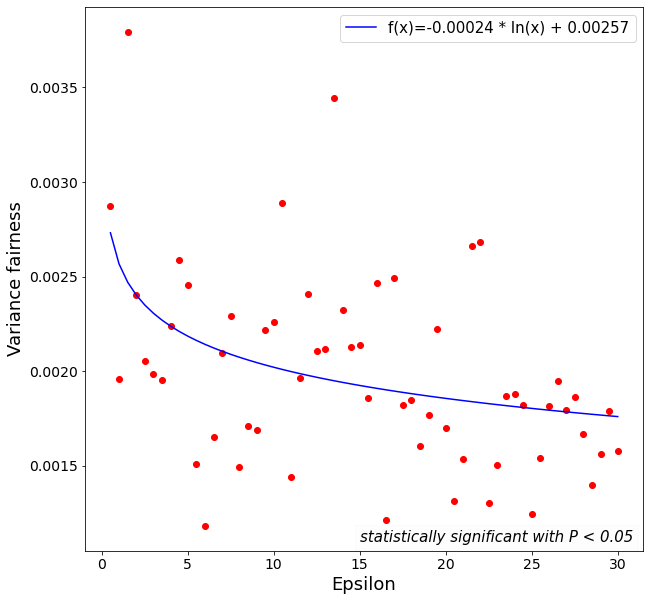

In [10]:
m, b = np.polyfit(np.log(epsilons), allvarF1, 1)

X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allvarF1, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allvarF1, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Variance fairness", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(15, 0.0011,'statistically significant with P < 0.05', fontsize=15,  color='black',style='italic', bbox={'facecolor': 'grey', 'alpha': 0.01, 'pad': 5})
plt.legend(loc="upper right", fontsize=15)
plt.savefig('5varf1Wilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     7.822
Date:                Sun, 13 Jun 2021   Prob (F-statistic):            0.00699
Time:                        13:46:27   Log-Likelihood:                 174.86
No. Observations:                  60   AIC:                            -345.7
Df Residuals:                      58   BIC:                            -341.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1488      0.005     29.566      0.0

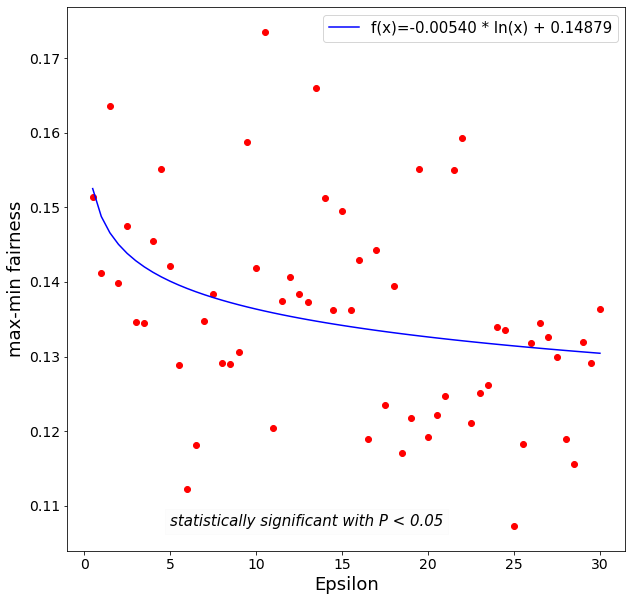

In [11]:
X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allminMaxF1, X2)
est2 = est.fit()
print(est2.summary())

m, b = np.polyfit(np.log(epsilons), allminMaxF1, 1)
plt.figure(figsize=(10,10))
plt.scatter(epsilons, allminMaxF1, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.xlabel("Epsilon", fontsize=18)
plt.text(5, min(allminMaxF1),'statistically significant with P < 0.05', fontsize=15,  color='black',style='italic', bbox={'facecolor': 'grey', 'alpha': 0.01, 'pad': 5})
plt.ylabel("max-min fairness", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper right", fontsize=15)
plt.savefig('5minmaxf1Wilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     7.625
Date:                Sun, 13 Jun 2021   Prob (F-statistic):            0.00770
Time:                        13:46:32   Log-Likelihood:                 170.34
No. Observations:                  60   AIC:                            -336.7
Df Residuals:                      58   BIC:                            -332.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6650      0.005    122.548      0.0

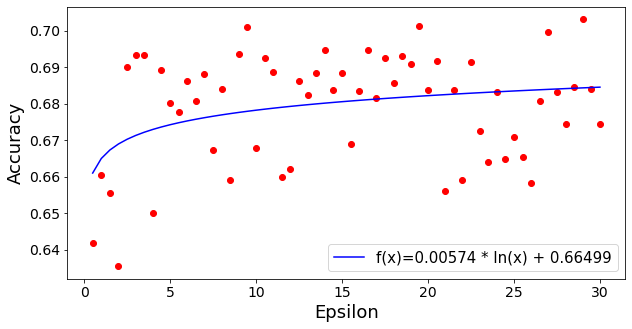

In [12]:
X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allaccuracy, X2)
est2 = est.fit()
print(est2.summary())

m, b = np.polyfit(np.log(epsilons), allaccuracy, 1)

plt.figure(figsize=(10,5))
plt.scatter(epsilons, allaccuracy, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right", fontsize=15)
plt.savefig('5accuracyWilds1to30eps.png', bbox_inches='tight')
plt.show()